I_b = 0.27
Rcsf = 6.66
E = 0.3
P_0 = 4.48
error = 0.7774



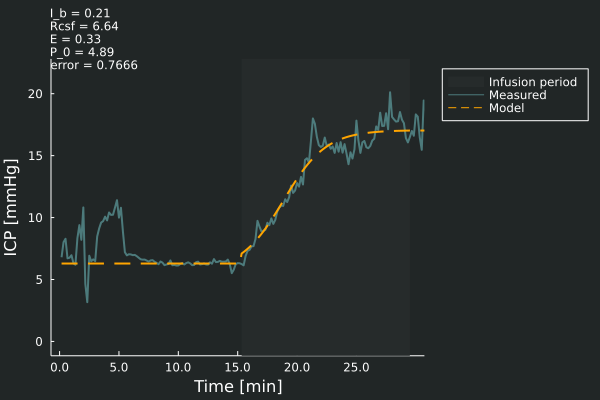

In [1]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=NaN, E=NaN, Ib=NaN, P0=NaN, mode=NaN, error=NaN, R2=NaN, Pss=NaN)

for j = 1141
    # try
        j in [278, 442, 521, 621, 676, 1043] ? (continue) : 0

        P_0 = nothing
        Pss = nothing
        GC.gc()

        filename = files[j]
        global Data = readCSF(filename)


        # diffRcsf, diffE, diffP0 = solveDerivatives()

        length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
        global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

        global lb = [0.1, 0.1, -10.0]
        global ub = [50.0, 1.0, Data["P_b"]]
        global Ib_upper = 1.0
        global Ib_lower = 0.0

        # optalg = Newton()
        optalg = NelderMead()
        x0 = [Data["Rcsf"], Data["E"], Data["P_0"]]
        result, min_val = local_opt(x0, optalg)

        global Rcsf, E, P_0 = Optim.minimizer(result)
        # global Rcsf = logit(Rcsf, lb[1], ub[1])
        # global E = logit(E, lb[2], ub[2])
        # global P_0 = logit(P_0, lb[3], ub[3])


        # global Rcsf = logit(Rcsf, lb[1], ub[1])
        # global Rcsf, E, P_0, Pss = Optim.minimizer(result)

        if typeof(Pss) != Nothing
            global df.Pss[j] = round(Pss, digits=3)
            global I_b = (Data["P_b"] - Pss) / Rcsf
        else
            global df.Pss[j] = round(P_0, digits=3)
            global I_b = (Data["P_b"] - P_0) / Rcsf
        end
        df.Rcsf[j] = round(Rcsf, digits=3)
        df.P0[j] = round(P_0, digits=3)
        df.Ib[j] = round(I_b, digits=3)
        df.E[j] = round(E, digits=3)
        df.filename[j] = filename[length(datapath)+2:end]
        df.error[j] = round(get_error_score(I_b, E, P_0), digits=3)
        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0)
        df.R2[j] = round(R2, digits=3)

        # plot_model(logit(I_b, Ib_lower, Ib_upper), logit(E, lb[2], ub[2]), logit(P_0, lb[3], ub[3]), Data["ICP"], 20, false)
        # plot_model(I_b, E, P_0, Data["ICP"], 20, false)
        # println(j)
    # catch
    #     println("failed at file $j")
    #     continue
    # end
end
CSV.write("/Users/jjc/CSF/Results/Results_NelderMead_StaticP0.csv", df);
println("I_b = $(Data["I_b"])\n", "Rcsf = $(Data["Rcsf"])\n", "E = $(Data["E"])\n", "P_0 = $(Data["P_0"])\n", "error = $(round(get_error_score(Data["I_b"], Data["E"], Data["P_0"]),digits=4))\n")
# plot_model(I_b, logit(E, lb[2], ub[2]), logit(P_0, lb[3], ub[3]), Data["ICP"], 20, false)
plot_model(I_b, E, P_0, Data["ICP"], 20, false)




In [ ]:
# BRUTEFORCE
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
Rdist = LinRange(0.0, 50.0, 200)
Edist = LinRange(0.0, 1.0, 100)
P0dist = LinRange(-10.0, Data["P_b"], 100)
# P0dist = zeros(100) .+ Data["P_0"]

# M = [[i,j,k, get_error_score((Data["P_b"] - k)/i, j, k)]  for i in Rdist, j in Edist, k in P0dist]
# M = [[i,j,k, get_error_score_Juniewicz((Data["P_b"] - k)/(i * Data["I_inf"]), j)]  for i in Rdist, j in Edist, k in P0dist]

a = reshape(M,2000000,1)

tormv = zeros(length(a))
for i = eachindex(a)
    isnan.(a[i][4]) ? a[i][4] = 10^12 : 0
    tormv[i] = a[i][4]
end

s = findmin(tormv)
s = s[2]
global Rcsf, E, P_0 = a[s][1], a[s][2], a[s][3]
# global I_b = (Data["P_b"] - P_0) / Rcsf
global I_b = (Data["P_b"] - P_0) / (Rcsf * Data["I_inf"])
get_error_score_Juniewicz(I_b, E)
# plot_model(I_b, a[s][2], a[s][3], Data["ICP"], 20, false)
# plot_model(I_b, a[s][2], Data["P_0"], Data["ICP"], 20, false)
fitErrorVal = 100 * sqrt(errorVal) / (Data["infusion_end_frame"] - Data["infusion_start_frame"]) / abs(mean(Data["ICP"][Data["infusion_start_frame"]:tslength]))
ICP = Data["ICP"][Data["infusion_start_frame"]:tslength]
err = 100*sqrt(sum((pseries .- ICP).^2))/length(ICP)/abs(mean(ICP))

# plot_model(I_b, E, P_0, Data["ICP"], 20, false)

# println(fitErrorVal)
# println(err)
plot(Data["ICP"][Data["infusion_start_frame"]:tslength], linewidth=2)
plot!(pseries, linewidth=2)
# P_0





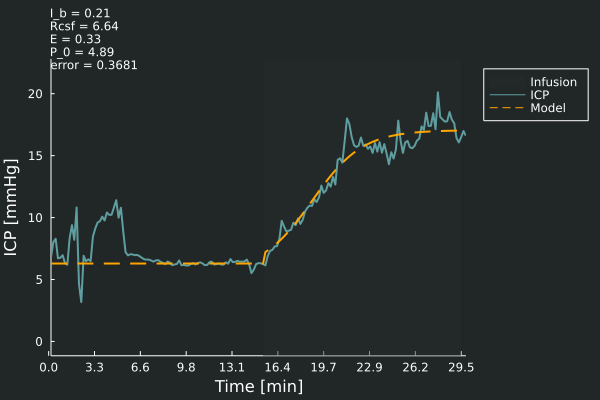

In [89]:
plotmodel(I_b, E, P_0, "dark")


In [ ]:
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
collect(0:30:infend)./6
plot_model(I_b, E, P_0, Data["ICP"], 20, false)